# Machine Learning Engineer Nanodegree
## Capstone Project
Qixiang Zhang  
Jul 3rd, 2018

### Sensitivity Analysis

In [1]:
##### EXPLORE #########==================
# data exploring and basic libraries
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import deque as dq

# NLP preprocessing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize as TK
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer

##### MODELING ######===================
# from time import time
# train test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# model eval
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# basic multi-class classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# binary class classification models
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# One vs All wrapper
from sklearn.multiclass import OneVsRestClassifier

# additional multi-class classification models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# deep learning
import tensorflow as tf
import keras

###### supplementary code#######

# Pretty display for notebooks
from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline

C:\Users\qixia\Anaconda3\envs\kitchen\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


### Load the datasets

In [2]:
# load the data - test data and change id column type to string
rawdf_te = pd.read_json(path_or_buf='raw_data/test.json').set_index('id')

In [3]:
# load the data - train data and change id column type to string
rawdf_tr = pd.read_json(path_or_buf='raw_data/train.json').set_index('id')

#### Preprocessing

In [4]:
# substitute the matched pattern
def sub_match(pattern, sub_pattern, ingredients):
    for i in ingredients.index.values:
        for j in range(len(ingredients[i])):
            ingredients[i][j] = re.sub(pattern, sub_pattern, ingredients[i][j].strip())
            ingredients[i][j] = ingredients[i][j].strip()
    re.purge()
    return ingredients

def regex_sub_match(series):
    # remove all units
    p0 = re.compile(r'\s*(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\s*[^a-z]')
    series = sub_match(p0, ' ', series)
    # remove all digits
    p1 = re.compile(r'\d+')
    series = sub_match(p1, ' ', series)
    # remove all the non-letter characters
    p2 = re.compile('[^\w]')
    series = sub_match(p2, ' ', series)
    return series

In [5]:
# declare instance from WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# remove all the words that are not nouns -- keep the essential ingredients
def lemma(series):
    for i in series.index.values:
        for j in range(len(series[i])):
            # get rid of all extra spaces
            series[i][j] = series[i][j].strip()
            # Tokenize a string to split off punctuation other than periods
            token = TK(series[i][j])
            # set all the plural nouns into singular nouns
            for k in range(len(token)):
                token[k] = lemmatizer.lemmatize(token[k])
            token = ' '.join(token)
            # write them back
            series[i][j] = token
    return series

In [6]:
# copy the series from the dataframe
ingredients_tr = rawdf_tr['ingredients']
# do the test.json while at it
ingredients_te = rawdf_te['ingredients']

In [7]:
# regex both train and test data
ingredients_tr = regex_sub_match(ingredients_tr)
ingredients_te = regex_sub_match(ingredients_te)

In [8]:
# lemmatize both train and test data
ingredients_tr = lemma(ingredients_tr)
ingredients_te = lemma(ingredients_te)

In [9]:
# copy back to the dataframe
rawdf_tr['ingredients_lemma'] = ingredients_tr
rawdf_tr['ingredients_lemma_string'] = [' '.join(_).strip() for _ in rawdf_tr['ingredients_lemma']]
# do the same for the test.json dataset
rawdf_te['ingredients_lemma'] = ingredients_te
rawdf_te['ingredients_lemma_string'] = [' '.join(_).strip() for _ in rawdf_te['ingredients_lemma']]

In [10]:
rawdf_tr.head()

,cuisine,ingredients,ingredients_lemma,ingredients_lemma_string
id,,,,
10259,greek,"[romaine lettuce, black olive, grape tomato, g...","[romaine lettuce, black olive, grape tomato, g...",romaine lettuce black olive grape tomato garli...
25693,southern_us,"[plain flour, ground pepper, salt, tomato, gro...","[plain flour, ground pepper, salt, tomato, gro...",plain flour ground pepper salt tomato ground b...
20130,filipino,"[egg, pepper, salt, mayonaise, cooking oil, gr...","[egg, pepper, salt, mayonaise, cooking oil, gr...",egg pepper salt mayonaise cooking oil green ch...
22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
13162,indian,"[black pepper, shallot, cornflour, cayenne pep...","[black pepper, shallot, cornflour, cayenne pep...",black pepper shallot cornflour cayenne pepper ...


In [11]:
rawdf_te.head()

,ingredients,ingredients_lemma,ingredients_lemma_string
id,,,
18009,"[baking powder, egg, all purpose flour, raisin...","[baking powder, egg, all purpose flour, raisin...",baking powder egg all purpose flour raisin mil...
28583,"[sugar, egg yolk, corn starch, cream of tartar...","[sugar, egg yolk, corn starch, cream of tartar...",sugar egg yolk corn starch cream of tartar ban...
41580,"[sausage link, fennel bulb, frond, olive oil, ...","[sausage link, fennel bulb, frond, olive oil, ...",sausage link fennel bulb frond olive oil cuban...
29752,"[meat cut, file powder, smoked sausage, okra, ...","[meat cut, file powder, smoked sausage, okra, ...",meat cut file powder smoked sausage okra shrim...
35687,"[ground black pepper, salt, sausage casing, le...","[ground black pepper, salt, sausage casing, le...",ground black pepper salt sausage casing leek p...


In [12]:
# DataFrame for training and validation
traindf = rawdf_tr[['cuisine', 'ingredients_lemma_string']].reset_index(drop=True)
print(traindf.shape)
traindf.head()

(39774, 2)


,cuisine,ingredients_lemma_string
0,greek,romaine lettuce black olive grape tomato garli...
1,southern_us,plain flour ground pepper salt tomato ground b...
2,filipino,egg pepper salt mayonaise cooking oil green ch...
3,indian,water vegetable oil wheat salt
4,indian,black pepper shallot cornflour cayenne pepper ...


In [13]:
testdf = rawdf_te[['ingredients_lemma_string']]
print(testdf.shape)
testdf.head()

(9944, 1)


,ingredients_lemma_string
id,
18009,baking powder egg all purpose flour raisin mil...
28583,sugar egg yolk corn starch cream of tartar ban...
41580,sausage link fennel bulb frond olive oil cuban...
29752,meat cut file powder smoked sausage okra shrim...
35687,ground black pepper salt sausage casing leek p...


In [14]:
# basically train_test_split customized to input cuisine name, outputs are 2 lists of indicies for train and test for the cuisine
def tt_split_1(cuisine, df):
    """choose 0.001 percent of the train.json for testing, the rest for training and validation"""
    cuisine_population = df.loc[(df['cuisine'] == cuisine)].index.values
    train, test = train_test_split(cuisine_population, test_size=0.0001)
    train = train.tolist()
    test = test.tolist()
    return train, test

def tt_split_2(cuisine, df, r):
    """split further to r_test ratio"""
    cuisine_population = df.loc[(df['cuisine'] == cuisine)].index.values
    train, test = train_test_split(cuisine_population, test_size=r)
    train = train.tolist()
    test = test.tolist()
    return train, test

#### hold for final testing

In [15]:
cuisine_list = rawdf_tr['cuisine'].unique().tolist()

# split the train.json to 99.999% train-valid and 0.001% test
ix_tr = [] # 99.999% for training and validation
ix_test = [] # 0.001% for the hold-out test (at least 1 from each cuisine)
for _ in cuisine_list:
    temp_train, temp_valid = tt_split_1(_, rawdf_tr)
    ix_tr += temp_train
    ix_test += temp_valid

# DataFrame for testing
testdf = rawdf_tr[['cuisine', 'ingredients_lemma_string']].loc[ix_test].reset_index(drop=True)
testdf['id'] = testdf.index.values
print('testdf shape: ',testdf.shape)
testdf.head()

testdf shape:  (20, 3)


,cuisine,ingredients_lemma_string,id
0,greek,salt ground black pepper fresh mint plain yogu...,0
1,southern_us,brown sugar pork tenderloin chopped onion cide...,1
2,filipino,kalamansi juice onion water round steak cookin...,2
3,indian,ground clove chickpea carrot frozen pea saffro...,3
4,jamaican,lime ginger cayenne pepper soy sauce honey pur...,4


In [16]:
# Drop the testing data aside
bag_df = rawdf_tr.drop(index=ix_test)

Create a module to split and fit 80-20 (same as the ratio in the project) on the 39754 data points, and predict the model for the sensitivity analysis on this 20 fixed data points

In [17]:
training_list = bag_df['cuisine'].unique().tolist()
le = LabelEncoder()

def preprocess(df, r):
    
    """
    split randomly each time further for train-valid 80-20 ratio
    input: dataframe, ratio
    output: training dataframe, validation dataframe
    """
    #initialize
    ix_train = [] # 80% for training
    ix_valid = [] # 20% aside
    temp_train = temp_valid = 0
    #split into index
    for _ in training_list:
         temp_train, temp_valid = tt_split_2(_, df, r)
         ix_train += temp_train
         ix_valid += temp_valid
    #copy to different dataframes
    traindf = df[['cuisine', 'ingredients_lemma_string']].loc[ix_train].reset_index(drop=True)
    validdf = df[['cuisine', 'ingredients_lemma_string']].loc[ix_valid].reset_index(drop=True)
    return traindf, validdf

def assign_x_y(traindf, validdf):
    
    """assign X_train, y_train, X_pred, y_true"""
    # X_train
    X_train_ls = traindf['ingredients_lemma_string']
    vectorizertr = TfidfVectorizer(stop_words='english', analyzer="word", max_df=0.65, min_df=2, binary=True)
    X_train = vectorizertr.fit_transform(X_train_ls)
    # y_train

    y_train = le.fit_transform(traindf['cuisine'])
    # predicting on 20 fixed data points see if anything changes
    # X_pred
    X_pred_ls = testdf['ingredients_lemma_string']
    vectorizerts = TfidfVectorizer(stop_words='english')
    X_pred = vectorizertr.transform(X_pred_ls)
    y_true = le.fit_transform(testdf['cuisine'])
    
    return X_train, y_train, X_pred, y_true

def predict_trials(classifier, col_name):
    
    df = pd.DataFrame()
    df['id'] = testdf.index.values
    df['cuisine'] = testdf['cuisine']
    # total error column
    df['e_total'] = 0
    num_trial = 10
    
    for k in range(num_trial):
        
        traindf, validdf = preprocess(rawdf_tr, 0.2)
        X_train, y_train, X_pred, y_true = assign_x_y(traindf, validdf)
        df['real_y'] = y_true
        
        # fit the model
        classifier = classifier.fit(X_train, y_train)
        
        # make predictions
        y_pred = classifier.predict(X_pred)
        
        # initialize error columns
        error_col = 'error_'+str(k)
        df[error_col] = np.zeros
        
        # store prediction
        y_pred_col = 'pred_y_'+str(k)
        df[y_pred_col] = y_pred
        
        # calculate the difference
        df[error_col] = np.where(abs(df[y_pred_col] - df['real_y'])>0, 1, 0)
        
        # add the errors
        df['e_total'] = df[error_col] + df['e_total']
    
    df[col_name] = (num_trial - df['e_total']) / num_trial
    
    return df[col_name]

`Fit the models ten times with different training and testing sets to see how the prediction for a specific cuisine changes with respect to the data it's trained on. Use the best parameters from grid search results for each models to fit the training data.`

###### Random Forest

In [18]:
# benchmark - RFC out of the box
df_rfc_bench = predict_trials(RandomForestClassifier(), 'bench')

# merge into 1 dataframe
df_sensi = pd.concat([testdf['cuisine'], df_rfc_bench], axis=1, sort=False)

In [19]:
# tuned random forest classifier
df_rfc = predict_trials(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=2,
            oob_score=True, verbose=0, warm_start=False), 'rfc')

df_sensi = pd.concat([df_sensi, df_rfc], axis=1, sort=False)

##### Multinomial Naive Bayes

In [20]:
# Best estimator after running the grid search cross validation for the Multinomial Naive Bayes model
df_mnb = predict_trials(MultinomialNB(alpha=0.035, class_prior=None, fit_prior=True), 'mnb')

df_sensi = pd.concat([df_sensi, df_mnb], axis=1, sort=False)

##### Logistic Regression

In [21]:
# Best estimator after running the grid search cross validation for the Logistic Regression (Multinomial) model
df_lr = predict_trials(LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=2, penalty='l2', solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False), 'lr')

df_sensi = pd.concat([df_sensi, df_lr], axis=1, sort=False)

##### Neural Network by sklearn

In [22]:
# Best estimator after running the grid search cross validation for the sklearn's neural network (MLPclassifier) model
df_mlp = predict_trials(MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), 'mlp')

df_sensi = pd.concat([df_sensi, df_mlp], axis=1, sort=False)

##### Logistic Regression with OVA

In [23]:
# Best estimator after running the grid search cross validation for the One-Versus-All Logistic Regression model
df_lr_ova = predict_trials(OneVsRestClassifier(
    estimator=LogisticRegression(
          C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=2,
          penalty='l2', solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),n_jobs=2), 'lr_ova')

df_sensi = pd.concat([df_sensi, df_lr_ova], axis=1, sort=False)

##### SVM with OVA

In [24]:
# Best estimator after running the grid search cross validation for the One-Versus-All SVM model
df_svm = predict_trials(SVC(C=3.25, cache_size=500, class_weight=None, coef0=0.0,\
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',\
  max_iter=-1, probability=False, shrinking=True,\
  tol=0.001, verbose=False), 'svm')

df_sensi = pd.concat([df_sensi, df_svm], axis=1, sort=False)

##### SGD with OVA

In [25]:
# Best estimator after running the grid search cross validation for the One-Versus-All SGD model
df_sdg = predict_trials(OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, 
       average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=None, n_jobs=2, penalty='l2', power_t=0.5, 
       shuffle=True, tol=None, verbose=0, warm_start=False), n_jobs=2), 'sdg_ova')

df_sensi = pd.concat([df_sensi, df_sdg], axis=1, sort=False)

##### XGBoost

In [26]:
# Best estimator after running the grid search cross validation for the XGBoost model
df_xgb = predict_trials(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.01, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=2, nthread=None, objective='multi:softprob', 
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8), 'xgb')

df_sensi = pd.concat([df_sensi, df_xgb], axis=1, sort=False)

C:\Users\qixia\Anaconda3\envs\kitchen\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\qixia\Anaconda3\envs\kitchen\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\qixia\Anaconda3\envs\kitchen\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\qixia\Anaconda3\envs\kitchen\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of

##### LightGBM

In [27]:
# LightGBM model
df_lgbm = predict_trials(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        gamma=1, learning_rate=0.01, max_depth=6, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
        n_jobs=2, num_leaves=31, objective='multiclass', 
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0), 'lgbm')

df_sensi = pd.concat([df_sensi, df_lgbm], axis=1, sort=False)

C:\Users\qixia\Anaconda3\envs\kitchen\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\qixia\Anaconda3\envs\kitchen\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\qixia\Anaconda3\envs\kitchen\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\qixia\Anaconda3\envs\kitchen\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of

##### Combined Result

In [28]:
df_sensi.to_csv('sensitivity_result.csv')

In [29]:
df_sensi

,cuisine,bench,rfc,mnb,lr,mlp,lr_ova,svm,sdg_ova,xgb,lgbm
0,greek,1.0,1.0,1.0,0.9,1.0,0.0,1.0,0.3,1.0,1.0
1,southern_us,0.8,0.7,0.0,0.0,0.4,0.1,0.8,0.3,0.6,0.0
2,filipino,0.8,0.9,0.8,1.0,0.9,0.9,0.7,1.0,1.0,1.0
3,indian,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,jamaican,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,spanish,1.0,0.7,0.0,0.0,0.0,0.2,0.7,0.0,0.7,0.0
6,italian,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,mexican,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,chinese,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,british,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.6


In [31]:
# average accuracy for each model
print('Model      Accuracy')
df_sensi.mean(axis=0)

Model      Accuracy


bench      0.940
rfc        0.935
mnb        0.740
lr         0.770
mlp        0.785
lr_ova     0.725
svm        0.940
sdg_ova    0.730
xgb        0.945
lgbm       0.740
dtype: float64

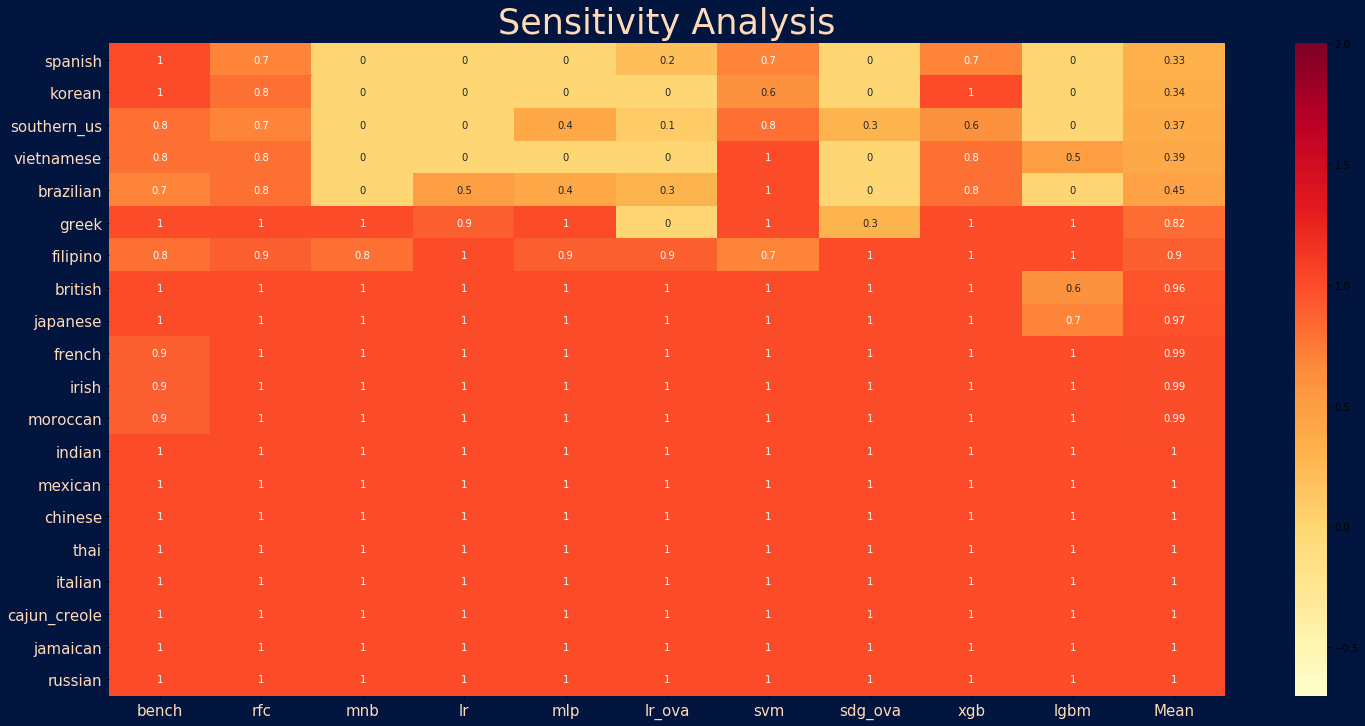

In [38]:
# sort the dataframe by the average value for each cuisine
df_sensi['Mean'] = df_sensi.mean(axis=1)
df_sensi = df_sensi.sort_values(by=['Mean'])
# add the data to numpy for plotting
sensi_array = df_sensi.drop(['cuisine'],axis=1).values

# plt setup
fig, ax = plt.subplots(1, 1, figsize=(25, 12), tight_layout=0)

# background color
fig.patch.set_facecolor('xkcd:navy')

# seaborn heatmap
g = sns.heatmap(sensi_array, annot=True, 
                xticklabels=list(df_sensi.columns.values[1:]), 
                yticklabels=df_sensi['cuisine'], 
                robust=1, vmin=-0.7, vmax=2,
                cmap='YlOrRd')
g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 15, color='peachpuff')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 15, color='peachpuff')

# add title
ax.set_title(label='Sensitivity Analysis', fontdict={'fontsize':35}, pad=10, color='peachpuff')

plt.show()

### Model Evaluation and justification (sorted by Kaggle's score):

| **Model** | **Grid Search Validation Score** |**Kaggle's Accuracy Score after submission** |
|----|----|----|
| SVM (One-Vs-All) | 0.8082 | 0.81114 |
| Neural Network by Keras | 0.7975 | 0.79444 |
| Logistic Regression (Multinomial) | 0.7896 | 0.78660 |
| Logistic Regression (One-Vs-All) | 0.7958 | 0.78620 |
| Neural Network (MLP Classifier by sklearn) | 0.7811 | 0.78278 |
| Linear Classifiers with SGD | 0.7797 | 0.78057 |
| XGBoost | 0.7710 | 0.77896 |
| Random Forest (tuned) | 0.7595 | 0.75905 |
| LightGBM | never finished running | 0.74064 |
| Naive Bayes (Multinomial) | 0.7424 | 0.73793 |
| **Random Forest (benchmark)** | -- | **0.70002** |

All the models end up producing much better results than the benchmark model (random forest out of the box). SVM (OVA) produced the highest accuracy **0.81114** which would have ended up on the **top 10%** of [Kaggle's Leaderboard](https://www.kaggle.com/c/whats-cooking/leaderboard) 2 years ago when the competition was still active. The deep learning with keras scored the second highest as **0.79444**, followed by the logistic regression base model.

As expected, the model with the highest validation score scored the highest on the testing data (SVM). The final models are reasonable and align with the solution expectations. The final parameters are appropriate and robust enough for the problem and the datasets. The result is evaluated by Kaggle after the submission.